# Density based clustering

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")

First, a normalization is needed.

In [151]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
scaler = QuantileTransformer()
X = scaler.fit_transform(quant.values)

It is necessary to embed the dataset in a lower-dimensional space. I choose to use ISOMAP

In [167]:
from sklearn.manifold import Isomap
isomap = Isomap(n_neighbors=10, n_components=2, p=2)
S = isomap.fit_transform(X)

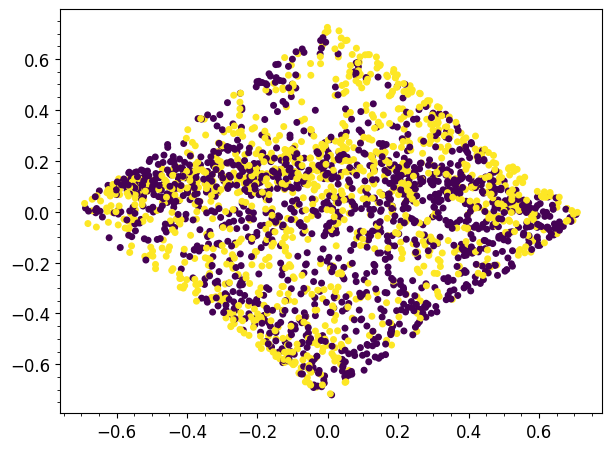

In [170]:
plt.scatter(S[:,0], S[:,1], c=pd.Categorical(categ.emotional_intensity).codes )

## DBSCAN

DBSCAN:
	number of custers = 1
	outliers 0


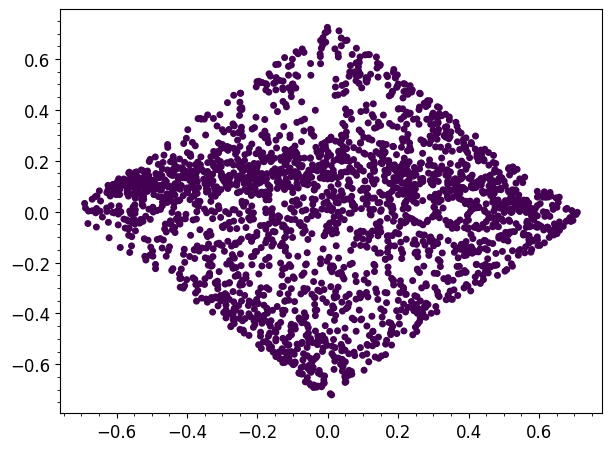

In [171]:
from sklearn.cluster import DBSCAN

cluster = DBSCAN(eps=0.32, min_samples=20).fit(X)
n_clusters_ = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)
n_noise_ = list(cluster.labels_).count(-1)

print(f"DBSCAN:\n\tnumber of custers = {n_clusters_}\n\toutliers {n_noise_}")
plt.scatter(S[:,0],S[:,1], c=cluster.labels_)

This is really sensitive to eps value, i try a raster scan

Max number of clusters (1.0) for eps = 0.1673684210526316


Text(0, 0.5, 'number of clusters')

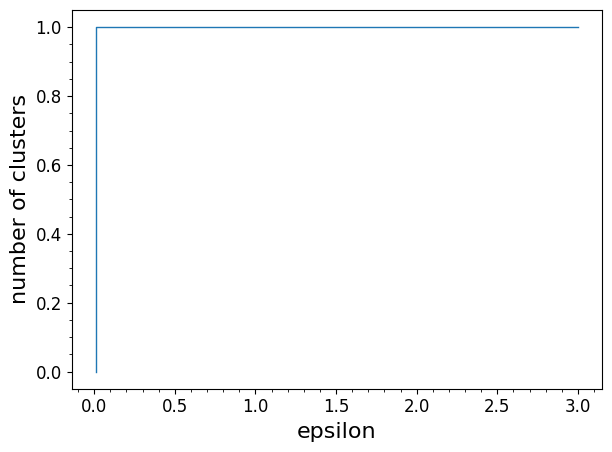

In [173]:
N=20
n = np.zeros(N)
epsilons = np.linspace(0.01, 3.0, N)
for i, eps in enumerate(epsilons):
    cluster = DBSCAN(eps=eps, min_samples=10).fit(X)
    n[i] = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)
print(f"Max number of clusters ({max(n)}) for eps = {epsilons[np.argmax(n)]}")
plt.step(epsilons, n)
plt.xlabel("epsilon")
plt.ylabel("number of clusters")

## OPTICS

OPTICS:
	number of custers = 7
	outliers 2237


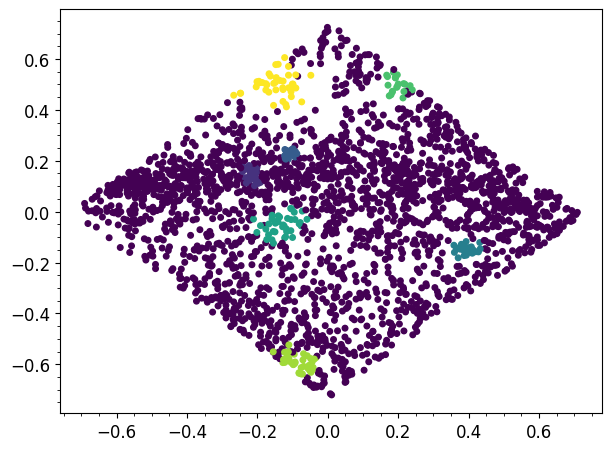

In [177]:
from sklearn.cluster import OPTICS

cluster = OPTICS(eps=50, min_samples=20).fit(X)
n_clusters_ = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)
n_noise_ = list(cluster.labels_).count(-1)

print(f"OPTICS:\n\tnumber of custers = {n_clusters_}\n\toutliers {n_noise_}")
plt.scatter(S[:,0],S[:,1], c=cluster.labels_)

### Analysis of the problematic features

From data understanding it is possible to see that `sc_min` and `stft_min` are not well distributed

Almost half of the dataset has zero sc_min. This seems to be a numeric effect.

DBSCAN:
	number of custers = 1
	outliers 0


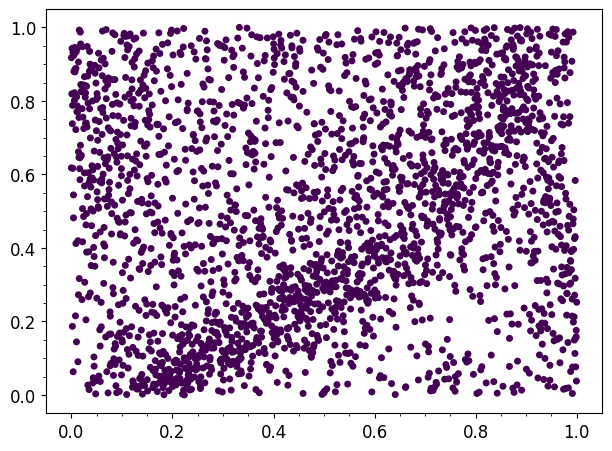

In [156]:
# DBSCAN over problematic features
X = QuantileTransformer().fit_transform(quant[["sc_min", "stft_min"]].values)
cluster = DBSCAN(eps=0.32, min_samples=20).fit(X)
n_clusters_ = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)
n_noise_ = list(cluster.labels_).count(-1)

print(f"DBSCAN:\n\tnumber of custers = {n_clusters_}\n\toutliers {n_noise_}")
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)

So the ratio of samples that has both these two variables equal to zero is:

In [157]:
print(((quant.sc_min==0)&(quant.stft_min==0)).sum()/len(quant)*100)

0.0


DBSCAN:
	number of custers = 85
	outliers 902


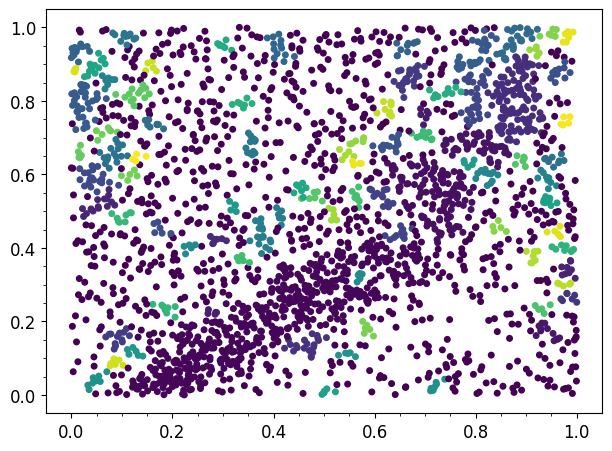

In [158]:
# DBSCAN over problematic features
X = QuantileTransformer().fit_transform(quant[["sc_min", "stft_min"]].values)
cluster = DBSCAN(eps=0.02, min_samples=5).fit(X)
n_clusters_ = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)
n_noise_ = list(cluster.labels_).count(-1)

print(f"DBSCAN:\n\tnumber of custers = {n_clusters_}\n\toutliers {n_noise_}")
plt.scatter(X[:,0],X[:,1], c=cluster.labels_)